# Подготовка данных и обучение нейронных сетей:

In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import torch, torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import torchvision.utils as vutils
from torchvision import transforms, models
import cv2
from bs4 import BeautifulSoup
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import shutil

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

# Код для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# Реализуем обучение нейронной сети, выполняющей детектирование объектов класса "person"

Имеется заранее размеченный датасет. Закачать можно по этой [ссылке](https://disk.yandex.ru/d/7HNoc81at3r6VQ)

Реализуем аугментацию данных, увеличив датасет вдвое. Для этого написал кастомную функцию aug:

In [3]:
from augment_and_visualize import *
aug(out_folder='augmented_dataset')

Исходное число фотографий и аннотаций = 500
Итоговое число фотографий и аннотаций = 1000


___

## Преподготовка данных для обучения сети Faster RCNN:

Разделим данные на тренировочные и тестовые:

In [3]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('augmented_dataset/images'):
    names.append(file.split('.')[0])

Рандомно поделим фотографии на train (80%) и test (20%)

In [4]:
train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на train = 800
Число изображений на test = 200


Аннотации в данном случае имеются в двух разлизных форматах СOCO_json и PASCAL_VOC_xml

#### Ключевое различие между xml и json разметкой боксов:
В __json__ каждый бокс имеет следующие 4 значения:<br>
_x_min, y_min, width, hight_ <br><br>
В __xml__ каждый бокс имеет следующие 4 значения:<br>
_x_min, y_min, x_max, y_max_

Рассмотрим как работать работать с данными аннотаций, представленными в формате xml

In [5]:
with open('detect_dataset/annotations/PASCAL_VOC_xml/oz7_violation_frame519.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
print(objects)

[<object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1000.3</xmin>
<ymin>301.6</ymin>
<xmax>1082.3</xmax>
<ymax>514.5</ymax>
</bndbox>
</object>, <object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1140.9</xmin>
<ymin>260.36</ymin>
<xmax>1215.6</xmax>
<ymax>493.2</ymax>
</bndbox>
</object>]


В данном случае информативная информация представлена в разделе _xmin_, _ymin_, _xmax_, _ymax_ и сам класс представлен в разделе _name_

In [6]:
# Создадим функции, которые как раз распарсят эти данные:
def generate_box(obj):
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    return [xmin, ymin, xmax, ymax]

'''
класс человек - 1
p.s:
    Я заранее прописал условия номеров классов
    для обучении следующей сети с двумя классами:
      1 -  человек с каской
      2 -  человек без каски
'''
def generate_label(obj):
    if (obj.find('name').text == "person") or (obj.find('name').text == "hat"):
        return 1
    elif obj.find('name').text == "no_hat":
        return 2   
    return 0

Pytorch как раз при обучении для моделей детекции тредует данные в формате [xmin, ymin, xmax, ymax] для каждого бокса

In [7]:
'''
Эта функция будет выдавать на выходе словарь с 3 ключами: boxes, labels и image_id.
На вход функция принимает:
image_id - индекс фотки из Dataset класса Pytorch 
file - путь к xml файлу
'''
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)

        # Будем итерироваться по листу, полученному после раскрытия xml файла:
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # В данном случае всего 1 класс 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # переведем индекс торч тензор
        img_id = torch.tensor([image_id])

        # получим итоговый словарь для исследуемой фотографии
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

Создадим класс MakeDataset, наследуя его от класса Dataset. Опишем методы _init_, _getitem_ и _len_

In [8]:
class MakeDataset(Dataset):
    def __init__(self, path, data, transforms=None):
        self.transforms = transforms
        self.names_list = data
        self.path = path

    def __getitem__(self, idx):
        name = self.names_list[idx]
        file_image = self.path + '/images/' + str(name) + '.jpg'
        file_label = self.path + '/annotations/' + str(name) + '.xml'
        img = Image.open(file_image).convert("RGB")

        #Сделаем словарь с аннотацией с помощью ранее написанной функции:
        target = generate_target(idx, file_label)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.names_list)

In [9]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

# На вход класса MakeDataset в __init__ подается значение списка файлов и 
# путь общей папке с аннотациями и изображениями:

train_dataset = MakeDataset(path='augmented_dataset', data=train_data, transforms=data_transform)
val_dataset = MakeDataset(path='augmented_dataset', data=test_data, transforms=data_transform)

Посмотрим в каком формате данные харнятся в классе MakeDataset:

In [10]:
first = train_dataset[7]
features, labels = first
print(labels)

{'boxes': tensor([[ 804.,  583., 1025., 1080.],
        [ 682.,  478.,  846.,  913.],
        [ 988.,  419., 1149.,  756.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([7])}


В данном случае на фотке есть 3 объекта класса человек, поэтому 3 bounding бокса

In [15]:
# Представляет значения в батчах как кортежи:
def collate_fn(batch):  
    return tuple(zip(*batch)) 


batch_size = 8  # Зададим чило фотографий на 1 батч

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Демонстрация выходных данных в класса DataLoader -> [batch_size, dicts]

In [16]:
device = 'cpu'
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[629., 132., 686., 261.]]), 'labels': tensor([1]), 'image_id': tensor([527])}, {'boxes': tensor([[593., 108., 633., 238.],
        [630.,  92., 690., 238.]]), 'labels': tensor([1, 1]), 'image_id': tensor([481])}]


---

## Визуализируем исходные изображения: 

Возьмем случайные 3 фотки и изобразим их боксы:


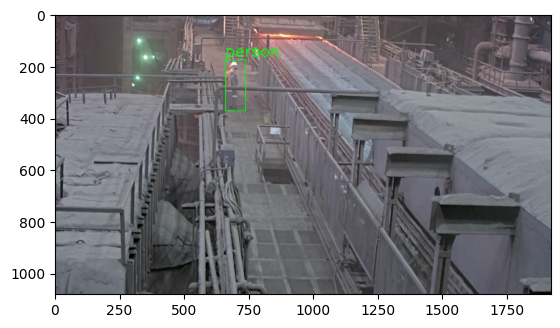

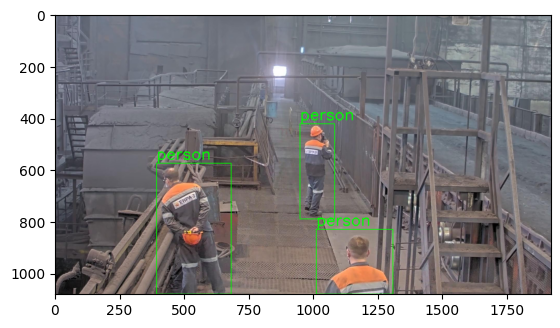

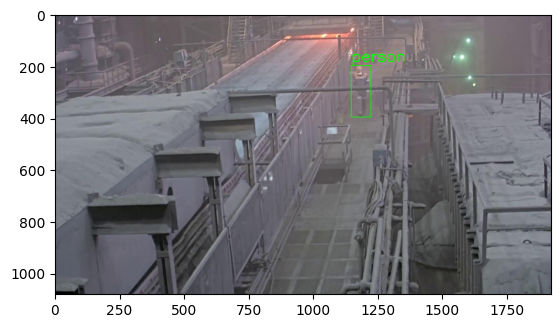

In [14]:
for _ in range(3):
    plot_random_image(train_data_loader)

---

## Конфигурация сети:

Будем использовать Transfer learning подход, обучая сеть Faster RCNN, которая была уже предобучена на COCO

In [17]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим число выходных класссов на то, что нам нужно
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Зададим модель (число классов задал как n+1, так как пустой 0 класс)
model = create_model(2)

Внутри реализации Faster R-CNN с FPN (Feature Pyramid Network) в библиотеке PyTorch torchvision используется сложная функция потерь, которая объединяет несколько подфункций.


In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Будем обучать сети на видеокарте:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model.to(device)
num_epochs = 30  # число эпох обучения

cuda


В данном случае выбор оптимизатора SGD может быть обусловлен следующими причинами:


Размер и сложность модели: Faster R-CNN с ResNet50-FPN — это достаточно большая и сложная модель с множеством обучаемых параметров, что может привести к быстрому переобучению и нестабильности при использовании более сложных оптимизаторов, таких как Adam.<br>
Количество и тип данных: при обучении объектных детекторов, основанных на Faster R-CNN, используется функция потерь, которая состоит из нескольких компонентов, включая компоненты, связанные с классификацией и регрессией объектов. SGD является классическим оптимизатором, который хорошо справляется с обучением таких моделей, в то время как Adam, который является более продвинутым методом, может не давать оптимальных результатов.<br>
Наличие предобученных весов: в данном случае мы используем предобученные веса для Faster R-CNN с ResNet50-FPN, что может упростить процесс обучения и позволить использовать более простой оптимизатор SGD вместо Adam.

In [19]:
# Создадим пустую папку, в которую будем сохранять обученные модели
newpath = 'models'
if not os.path.exists(newpath):
    os.makedirs(newpath)


In [42]:
# Запустим прямо в ноутбуке TensorBoard:
%reload_ext tensorboard
%tensorboard --logdir 'result'

Forward path для модели на трейне дает на выходе loss_dict, который представляет словарь, содержащий значения функции потерь для каждой из компонентов Faster R-CNN, используемых во время обучения. Словарь loss_dict в модели Faster R-CNN включает следующие компоненты функции потерь:

1. Loss_objectness отвечает за определение, содержит ли регион предполагаемого объекта какой-либо объект или нет (бинарная классификация). Для этого loss_objectness использует бинарную кросс-энтропию между выходом сети и соответствующими метками для каждого региона.

2. Loss_classifier отвечает за определение, к какому классу принадлежит объект в данном регионе. Для этого loss_classifier использует многоклассовую кросс-энтропию между выходом сети и соответствующими метками классов для каждого региона.
3. Loss_box_reg отвечает за определение насколько хорошо модель прогнозирует корректные координаты ограничивающего прямоугольника (bounding box) для обнаруженного объекта на изображении. Для этого loss_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

4. Loss_rpn_box_reg отвечает за определение насколько хорошо модель прогнозирует координаты ограничивающего прямоугольника (bounding box) для регионов, полученных от Region Proposal Network (RPN), которые могут содержать объекты. Для этого loss_rpn_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

## Код обучения сети:

Загрузим кастомую функцию и проведем обучение сети (30 эпох обучения):

In [20]:
from training_rcnn import *

train(model=model, train_data_loader=train_data_loader, optimizer=optimizer,
      val_data_loader=val_data_loader,
      num_epochs=30, comment=' person detection new', device=device,
      save_path='models/model_human_detection.pth')

Идет обучение 1 эпохи (из 30)


25it [01:56,  4.66s/it]


Train summ loss after 1 epochs = 0.4208124876022339


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Validation summ loss after 1 epochs = 0.3061984747648239
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 2 эпохи (из 30)


25it [00:42,  1.70s/it]


Train summ loss after 2 epochs = 0.28748080134391785


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Validation summ loss after 2 epochs = 0.25562007233500483
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 3 эпохи (из 30)


25it [00:41,  1.66s/it]


Train summ loss after 3 epochs = 0.25864553451538086


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Validation summ loss after 3 epochs = 0.20621072836220264
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 4 эпохи (из 30)


25it [00:40,  1.63s/it]


Train summ loss after 4 epochs = 0.19632981717586517


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Validation summ loss after 4 epochs = 0.17555233638733625
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 5 эпохи (из 30)


25it [00:40,  1.64s/it]


Train summ loss after 5 epochs = 0.175559863448143


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Validation summ loss after 5 epochs = 0.1646965214982629
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 6 эпохи (из 30)


25it [00:41,  1.65s/it]


Train summ loss after 6 epochs = 0.17309701442718506


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Validation summ loss after 6 epochs = 0.15319391686469316
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 7 эпохи (из 30)


25it [00:41,  1.66s/it]


Train summ loss after 7 epochs = 0.14986199140548706


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Validation summ loss after 7 epochs = 0.15249554138630628
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 8 эпохи (из 30)


25it [00:38,  1.54s/it]


Train summ loss after 8 epochs = 0.14288924634456635


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Validation summ loss after 8 epochs = 0.15483429674059151
Идет обучение 9 эпохи (из 30)


25it [00:38,  1.54s/it]


Train summ loss after 9 epochs = 0.1239708960056305


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Validation summ loss after 9 epochs = 0.1491524400189519
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 10 эпохи (из 30)


25it [00:40,  1.63s/it]


Train summ loss after 10 epochs = 0.13412560522556305


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Validation summ loss after 10 epochs = 0.15322665438055993
Идет обучение 11 эпохи (из 30)


25it [00:40,  1.62s/it]


Train summ loss after 11 epochs = 0.14917249977588654


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Validation summ loss after 11 epochs = 0.13551455199718476
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 12 эпохи (из 30)


25it [00:42,  1.68s/it]


Train summ loss after 12 epochs = 0.12813904881477356


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Validation summ loss after 12 epochs = 0.14124435190111398
Идет обучение 13 эпохи (из 30)


25it [00:42,  1.68s/it]


Train summ loss after 13 epochs = 0.13435494899749756


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Validation summ loss after 13 epochs = 0.13705324977636338
Идет обучение 14 эпохи (из 30)


25it [00:42,  1.69s/it]


Train summ loss after 14 epochs = 0.12711763381958008


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


Validation summ loss after 14 epochs = 0.1285201156511903
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 15 эпохи (из 30)


25it [00:42,  1.69s/it]


Train summ loss after 15 epochs = 0.11187738180160522


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Validation summ loss after 15 epochs = 0.12233510714024305
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 16 эпохи (из 30)


25it [00:42,  1.68s/it]


Train summ loss after 16 epochs = 0.11516410857439041


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Validation summ loss after 16 epochs = 0.1339443540200591
Идет обучение 17 эпохи (из 30)


25it [00:42,  1.70s/it]


Train summ loss after 17 epochs = 0.13242219388484955


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Validation summ loss after 17 epochs = 0.13391438439488412
Идет обучение 18 эпохи (из 30)


25it [00:39,  1.56s/it]


Train summ loss after 18 epochs = 0.1020960584282875


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 18 epochs = 0.12769309725612402
Идет обучение 19 эпохи (из 30)


25it [00:39,  1.57s/it]


Train summ loss after 19 epochs = 0.11947590857744217


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 19 epochs = 0.1253728786483407
Идет обучение 20 эпохи (из 30)


25it [00:38,  1.56s/it]


Train summ loss after 20 epochs = 0.1314164698123932


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 20 epochs = 0.12693745847791432
Идет обучение 21 эпохи (из 30)


25it [00:39,  1.56s/it]


Train summ loss after 21 epochs = 0.1341387778520584


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Validation summ loss after 21 epochs = 0.11963485933840275
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 22 эпохи (из 30)


25it [00:39,  1.58s/it]


Train summ loss after 22 epochs = 0.09956735372543335


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 22 epochs = 0.121691784709692
Идет обучение 23 эпохи (из 30)


25it [00:39,  1.57s/it]


Train summ loss after 23 epochs = 0.1082659661769867


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Validation summ loss after 23 epochs = 0.12000481735914946
Идет обучение 24 эпохи (из 30)


25it [00:39,  1.57s/it]


Train summ loss after 24 epochs = 0.12322945147752762


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 24 epochs = 0.12352910719811916
Идет обучение 25 эпохи (из 30)


25it [00:39,  1.56s/it]


Train summ loss after 25 epochs = 0.10063454508781433


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 25 epochs = 0.11771884977817536
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 26 эпохи (из 30)


25it [00:39,  1.58s/it]


Train summ loss after 26 epochs = 0.11039666086435318


100%|██████████| 100/100 [01:03<00:00,  1.59it/s]


Validation summ loss after 26 epochs = 0.12685358263552188
Идет обучение 27 эпохи (из 30)


25it [00:38,  1.55s/it]


Train summ loss after 27 epochs = 0.10834603011608124


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Validation summ loss after 27 epochs = 0.12323746003210545
Идет обучение 28 эпохи (из 30)


25it [00:39,  1.56s/it]


Train summ loss after 28 epochs = 0.09104762971401215


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Validation summ loss after 28 epochs = 0.11854852609336376
Идет обучение 29 эпохи (из 30)


25it [00:38,  1.55s/it]


Train summ loss after 29 epochs = 0.11474072933197021


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Validation summ loss after 29 epochs = 0.11717739876359701
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 30 эпохи (из 30)


25it [00:38,  1.56s/it]


Train summ loss after 30 epochs = 0.11799561977386475


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

Validation summ loss after 30 epochs = 0.1211331234127283
Обучение завершено


Tensorboard с обучением сохранен в директорию results. Так же я сохранил его на сайте dev, чтобы можно было смотреть по ссылке. <br>
__!!! Результаты обучения можно посмотреть перейдя по данной [ссылке](https://tensorboard.dev/experiment/rr43qafqQKyKP7CQ5r1RCA/#scalars&_smoothingWeight=0)__

Загрузка самого успешного состояния модели:<br>
Такую модель на всякий случай я переименовал в model_human_detection_final.pth чтобы случайно при повторном запуске кода не перезаписать. Данная модель имеет состояние нейронов, соответсвующее эпохе, на которой получилось добиться самого низкого значения лосса валидации

Так как файл с моделью весит слишком много (158 Мб), поэтому на github залить обученную модель не вышло. Так что для того, чтобы запустить самостоятельно код с использованием моей обученной модели необходимо запустить эту функцию, которая с моего гугл диска скачает в папку models обученные сети:

In [ ]:
#download_models(folder_name='models') 

Загрузим модель model_human_detection_final.pth:

In [21]:
model = create_model(2)
model.load_state_dict(torch.load('models/model_human_detection_final.pth'))

<All keys matched successfully>

---

## Тестирование:
Запустим кастомную функцию, которая реализует выведение результатов работы модели

Объектов класса person обнаружено 2


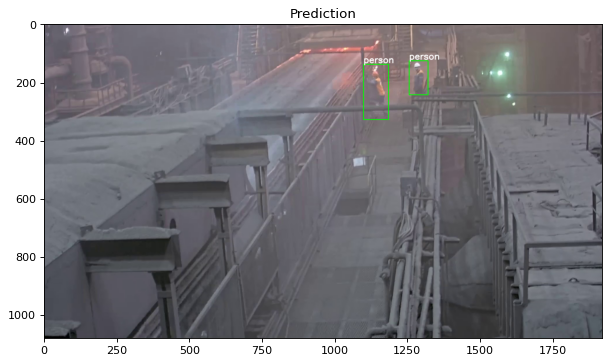

Объектов класса person обнаружено 3


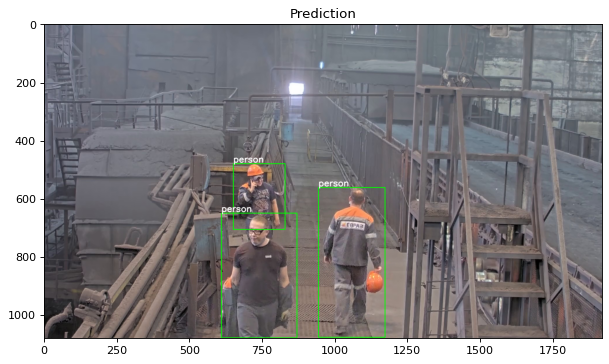

In [ ]:
from predict import *
detect_and_visualize(image_input='detect_dataset/images/am3_7_violation_frame143.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)
detect_and_visualize(image_input='detect_dataset/images/am3_9_frame111.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)

---

## Оценка качества модели:

Для подсчета метрик в задачах детекции объектов обычно используется два порога: порог для классификации (classification threshold) и порог для определения пересечения с истинным положением объекта (intersection over union, IoU threshold). <br>
Порог для классификации определяет, какие предсказания считать положительными, а какие отрицательными. Обычно порог устанавливают на основе score, который выдает модель для каждого обнаруженного объекта. Если score превышает порог, то объект считается положительным, в противном случае - отрицательным. <br>
Порог для определения IoU определяет, насколько сильно обнаруженный объект пересекается с истинным положением объекта. Обычно IoU threshold устанавливают на основе заданных требований к качеству обнаружения. Если IoU между обнаруженным объектом и истинным положением объекта превышает порог, то объект считается истинно обнаруженным, в противном случае - ложно обнаруженным. <br>
Таким образом, для подсчета метрик в задачах детекции объектов необходимо знать два порога: порог для классификации и порог для определения IoU. Они позволяют отделить положительные и отрицательные примеры и определить, насколько хорошо модель обнаруживает истинные положения объектов.<br><br>
Важная ремарка - порог по score используется на боевом дежурстве модели в продакшене, так что его стоит выбирать особенно вдумчиво. А вот IoU порог используется лишь на валидации для оценки нескольких известных метрик (о них я чуть позже расскажу в своем повествовании)

Выберем за treshold значение score = 0.85 

Оценим качество модели используя метрику IOU:

In [22]:
'''
Найдем первым этапом iou scores:
Получим массив с числом элементов равным чилу объектов в датасете 
и содержащим массив соответвий IOU между предсказанным и рельным bounding боксом
'''
from metrics import calculate_iou
iou_scores_list = calculate_iou(model, val_dataset, treshold=0.85)

Увидем как выглядят данные в данном массиве:

In [23]:
print(f'Пример 1:\n {iou_scores_list[10]}')
print(f'Пример 2: \n {iou_scores_list[67]}')

Пример 1:
 tensor([[0.8510]])
Пример 2: 
 tensor([[0.9405]])


Получаем матрицы iou, которые содержат значения коэффициентов IoU между всеми парами рамок из предсказанных и реальных боксов. Эти значения будут лежать в диапазоне от 0 до 1, где значение 0 означает, что рамки не пересекаются, а значение 1 означает, что рамки совпадают полностью.

Вычислим средний IOU на валидации при заданном пороге score = 0.85

In [24]:
val = []
for image in iou_scores_list:
    for detect in image:
        val.append(max(detect))
print(f'Средний IOU на валидации равен: {np.mean(val)}')

Средний IOU на валидации равен: 0.8235985636711121


Визуализируем как выглядят предсказанные и реальные bounding боксы на изображениях из валидационного датасета и найдем IOU для них:<br>
ps (в данной кастомной функции строятся сразу все предсказанные боксы, для которых score>0)

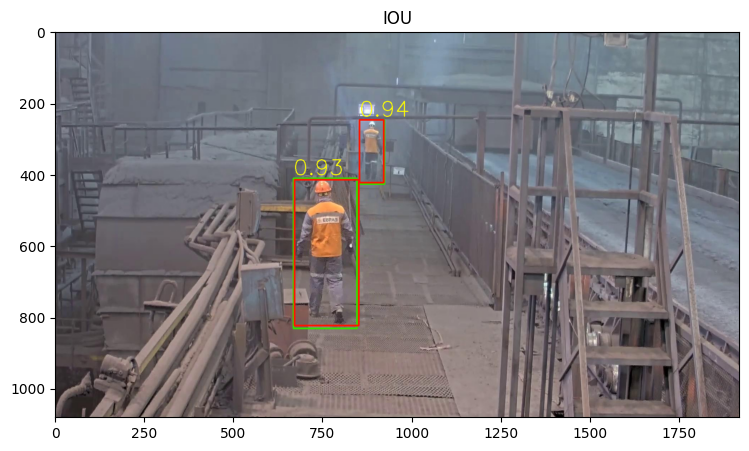

In [99]:
visualize_detection(val_dataset, model, 26)

### Вычислим precission и recall:


Recall для задачи одноклассовой детекции показывает, как много из всех объектов интереса были обнаружены алгоритмом. То есть, чем ближе значение recall к 1, тем больше объектов интереса было найдено алгоритмом.

Precision для задачи одноклассовой детекции показывает, как много из всех предсказанных алгоритмом ограничивающих рамок действительно содержат объекты интереса. То есть, чем ближе значение precision к 1, тем меньше ложных объектов было предсказано алгоритмом.

Для вычисления данных метрик зададим порог по IOU равным 0.5

Подсчет метрик для одной конкретной фотки:

In [25]:
from metrics import *

# Искусственный пример всего 3 объекта реально имелось, но 4 обнаружены
# при выбранном пороге score с такими значениями IOU:

score = torch.tensor([[0.20, 0.90, 0.10],
                      [0.80, 0.10, 0.20],
                      [0.00, 0.10, 0.20],
                      [0.10, 0.20, 0.00]])

print('recall (iou=0.1) =', recall(score, iou_threshold=0.1))
print('precission (iou=0.1) =', precision(score, iou_threshold=0.1))
print('recall (iou=0.5) =', recall(score, iou_threshold=0.5))
print('precission (iou=0.5) =', precision(score, iou_threshold=0.5))
print('recall (iou=0.85) =', recall(score, iou_threshold=0.85))
print('precission (iou=0.85) =', precision(score, iou_threshold=0.85))

recall (iou=0.1) = 1.0
precission (iou=0.1) = 0.75
recall (iou=0.5) = 0.6666666666666666
precission (iou=0.5) = 1
recall (iou=0.85) = 0.3333333333333333
precission (iou=0.85) = 1


In [26]:
#Подсчет средей метрики для всего датасета при порге score 0.85:
print('Средний recall по всему валидационному датасету =',
      mean_metric(iou_scores_list, func='recall', iou_treshold=0.5))
print('Средний precision по всему валидационному датасету =',
      mean_metric(iou_scores_list, func='precision', iou_treshold=0.5))

Средний recall по всему валидационному датасету = 0.9708333333333333
Средний precision по всему валидационному датасету = 1.0


Пояснение к полученным результатам:

Если алгоритм детекции выделяет множество регионов на фотографии, которые имеют высокое сходство с реальным объектом, но при этом эти регионы на самом деле не соответствуют объекту (куча predict боксов рядом с человеком как в YOLO без non-maximum supression), то для данного случая recall будет высоким, а precision будет низким.

В нашем случае выбран порог уверенности в детекции очень высоким (score = 0.85), поэтому у нас ситуация как раз обратная. Чаще классификаор вовсе не найдет человека, нежели найдет его дважды. По этой причине precision у нас очень высокий, а recall имеет ниже значение.


Вычислим метрику __Average Precision__ <br>
При вычислении AP мы изменяем порог по score (уверенности модели) и вычисляем соответствующие значения precision и recall для каждого порога. При этом precision и recall могут изменяться, в зависимости от выбранного порога.
Когда порог на score установлен на очень высоком уровне, то есть модель детектирует только объекты, которые она считает наиболее уверенными, то precision будет очень высоким, но recall будет низким, поскольку многие объекты могут быть пропущены. Если порог установлен на очень низком уровне, то есть модель детектирует все объекты, но и много шума (ложных обнаружений), то recall будет высоким, но precision будет низким.<br>
При этом AP является средним значением точности при выборе порога на score с 0 до 1, при котором recall изменяется от 0 до 1. AP учитывает важность как точности, так и полноты при вычислении качества алгоритма детектирования объектов и не учитывает выбор конкретного score порога, что позволяет дать более общую оценку качества модели детектирования.
Т.к в данной задаче класс детектируемый всего один, поэтому метрика mAP (mean AP) = AP

In [27]:
rec=[]
prec = []
for i in np.linspace(0, 1, num=11, endpoint=False):
    iou_scores_list = calculate_iou(model, val_dataset, treshold=i)
    rec.append(mean_metric(iou_scores_list, func='recall', iou_treshold=0.5))
    prec.append(mean_metric(iou_scores_list, func='precision', iou_treshold=0.5))
rec.append(0)
prec.append(1)

__Построение precision_recall_curve:__ <br>

AP можно определить как площадь под графиком Precision-Recall curve. Изобразим данный график, построенный при выборе порога IoU = 0.5

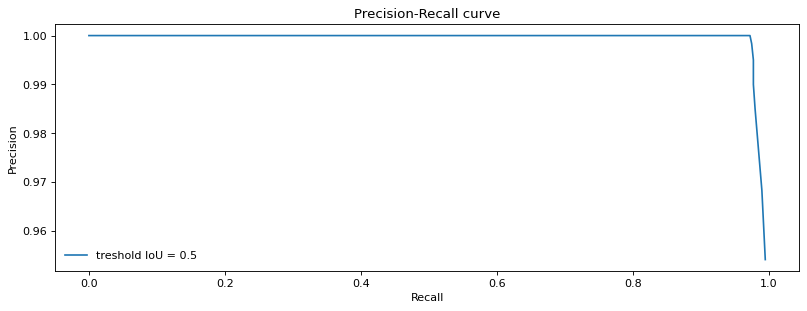

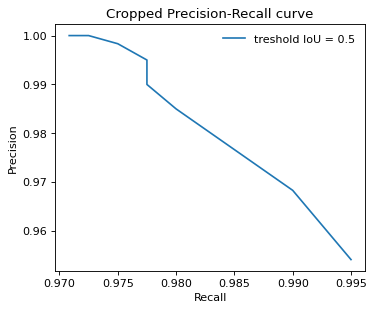

In [28]:
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(rec, prec, label="treshold IoU = 0.5")
plt.title('Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(frameon=False)
plt.show()

plt.figure(figsize=(5, 4), dpi=80)
plt.plot(rec[:-1], prec[:-1], label="treshold IoU = 0.5")
plt.title('Cropped Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(frameon=False)
plt.show()


Определение среднего Average Precision (AP) по изображениям валидационного датасета при IoU=5:

In [29]:
print(f'Average precision = {average_precision(prec, rec)}')

Average precision = 0.9944000000000001


В данном случае мы реализовывали самостоятельный расчет метрики AP и в итоге вычислили при IoU=0.5 значения AP для каждой фотки по отдельности и после этого усреднили метрику по всему валидационному датасету.Такой подход не совсем является правильным. Стоит искать эту метрику сразу сконкатинировав результаты детектирования и ground truth для всех изображений в валидационном датасете. Тогда случайно хорошее детектирование на нескольких отдельных изображениях не сделают результаты AP при оценке качества модели менее информативными.<br>
Реализуем описанный подход используя готовые функции из torchmetrics.detection:


In [30]:
mAP_AP_dataset(val_dataset, model)

100%|██████████| 200/200 [09:51<00:00,  2.96s/it]




Значения Average Precision для класса person:
AP (при IoU=.50) = 0.971


## __Вывод по одноклассовой детекции:__<br>
Мы обучили довольно сложную модель Faster RCNN и получили очень высокие значения метрик качества на валидации. <br>
Причиной таких высоких метрик является то, что для данной задачи имелся досаточно большой тренировочный датасет, всего требовалоь детектировать лишь 1 класс, что делает задачу достаточно простой. 
А самое главное то, что весь датасет представлен в виде фотографий с нескольких неподвижных камер, так что снимки на валидации и на трейне, к сожалению, очень друг на друга похожи. Даже использование аугментации не сильно вносит разнообразия в наш исследуемый датасет. Так что стоит предполагать, что при использовании данной предобученной сети на абсолютно иных (отличных) снимках, сеть будет показывать существенно более низкие результаты качества.

### Пример работы на незнакомой непохожей фотографии:

Объектов класса person обнаружено 5


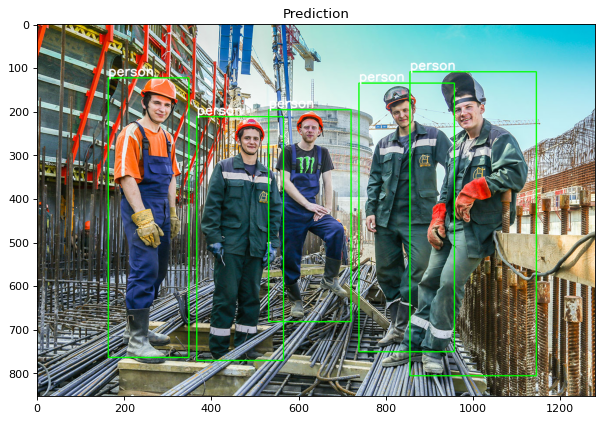

Объектов класса person обнаружено 5


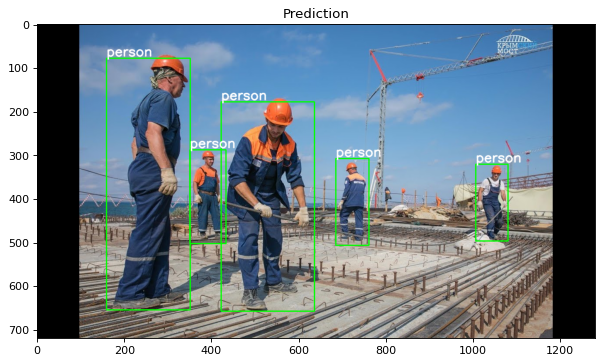

Объектов класса person обнаружено 10


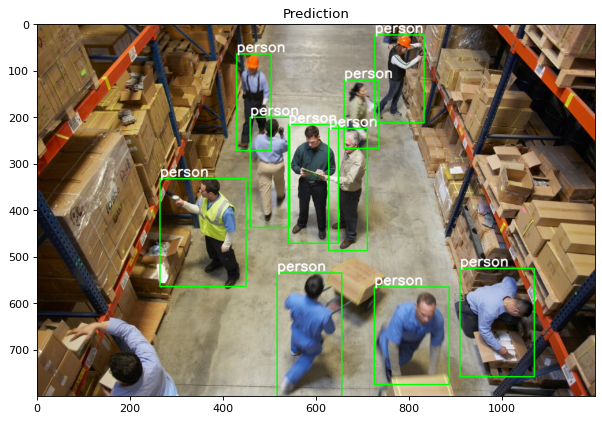

In [31]:
detect_and_visualize(image_input='test_folder/1.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)
detect_and_visualize(image_input='test_folder/2.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)
detect_and_visualize(image_input='test_folder/3.jpg',
                     model_path='models/model_human_detection_final.pth',
                     classes=['person'], plt_show=True)

---

---

---

# Детекция людей с каской с без:

С помощью вэб сервиса https://www.makesense.ai/ я самостоятельно разметил часть изображений, сделав на этот раз 2 отдельных класса - __человек с каской на голове__ и __человек без каски__. <br>
Датасет, содержащий новую аннотацию можно скачать по этой [ссылке](https://disk.yandex.ru/d/H4Qa16XDre6uuQ) <br><br>


_По поводу процедуры создания подходящего датасета для обучения модели:_<br> Первоначально я разметил фотографии, выделяя целиком фигуру человека и указывая класс объекта (имеется или нет на нем каска), но такой подход не дал хороших результатов. Из-за слишком значимой неравномерности числа объектов между классами я получал очень низкий recall на класс with hardhat. (т.к в датасете 95% фотографий именно с людьми в касках).<br>
Чуть лучше результаты я смог получить, искусственно снизив число примеров с классом with hardhat (тем самым размер датасета снизился до 93 фотографий) и сделав разметку боксов не по области тела человека, а лишь области головы. То есть в боксе находится 2 возможных класса: голова с надетой каской и непокрытая голова.

Результирующие аннотации я сохранил в папке detect_hat_dataset/annotations <br>
Теперь добавим в пока еще пустую папку detect_hat_dataset/images изображения, соответсвующие данным аннотациям (отберем по совпадающему названию)

In [45]:
# Создадаим пустую папку images:
newpath = 'detect_hat_dataset/images'
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
# Получим имена файлов аннотаций нового датасета без значения кодировки
names = []
for file in os.listdir('detect_hat_dataset/annotations'):
    names.append(file.split('.')[0])
print(f'Всего вручную размеченных фотографий {len(names)} штук')

Всего вручную размеченных фотографий 93 штук


Скопируем из папки detect_dataset/images подходящие фотки в папку detect_hat_dataset/images:

In [46]:
for file in os.listdir('detect_dataset/images'):
    if file.split('.')[0] in names:
        shutil.copy2('detect_dataset/images/' + file, 'detect_hat_dataset/images')

Так как в данном случае изображений размеченных особенно мало, поэтому воспользуемся готовой функцией аугментации для увеличения размера датасета в 2 раза:

In [ ]:
aug(image_dir="detect_hat_dataset/images",
    xml_dir="detect_hat_dataset/annotations",
    out_folder='augmented_hat_dataset')

Исходное число фотографий и аннотаций = 93
Итоговое число фотографий и аннотаций = 186


Теперь у нас есть папка augmented_hat_dataset с которой мы и будем работать при обучении сети

---

Реализация предподгтовки данных абсолютно идентична, поэтому с более сжатым текстовым пояснением реализуем все процессы:

In [31]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('augmented_hat_dataset/images'):
    names.append(file.split('.')[0])

In [32]:
#Рандомно поделим фотографии на train (80%) и test (20%)

train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на train = 148
Число изображений на test = 38


In [33]:
train_dataset = MakeDataset(path='augmented_hat_dataset', data=train_data, transforms=data_transform)
val_dataset = MakeDataset(path='augmented_hat_dataset', data=test_data, transforms=data_transform)

batch_size = 8  # Зададим чило фотографий на 1 батч

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

### Визуализируем исходные изображения:
Возьмем случайные 3 фотки и изобразим их боксы:

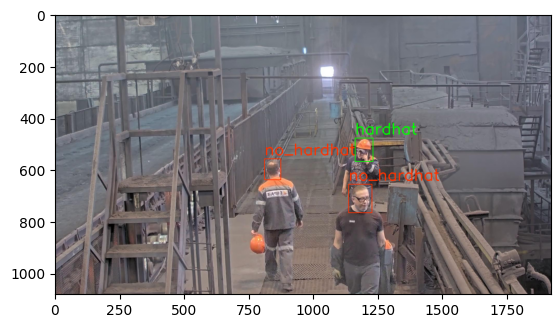

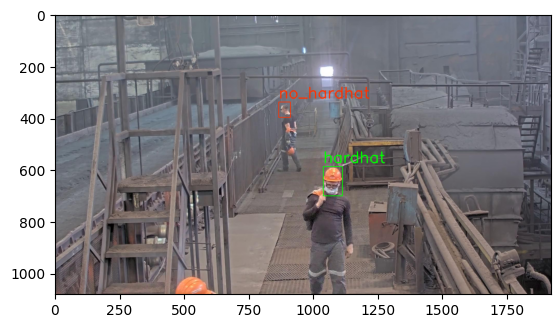

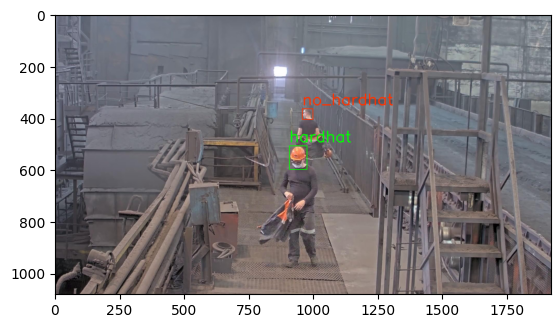

In [42]:
for _ in range(3):
    plot_random_image(train_data_loader, hat_class=True)

Зададим модель и ее параметры.<br>
На этот раз классов уже будет 3:<br>
_фон, человек с каской и человек без каски_

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = create_model(3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


cuda


---

## Обучение сети:

In [35]:
from training_rcnn import *

train(model=model, train_data_loader=train_data_loader, optimizer=optimizer,
      val_data_loader=val_data_loader,
      num_epochs=30, comment=' hardhat detection new', device=device,
      save_path='models/model_hardhat_detection.pth')

Идет обучение 1 эпохи (из 30)


25it [00:39,  1.58s/it]


Train summ loss after 1 epochs = 0.516562819480896


100%|██████████| 19/19 [00:13<00:00,  1.46it/s]


Validation summ loss after 1 epochs = 0.40158786154107046
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 2 эпохи (из 30)


25it [00:38,  1.54s/it]


Train summ loss after 2 epochs = 0.38379207253456116


100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


Validation summ loss after 2 epochs = 0.38813313449683945
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 3 эпохи (из 30)


25it [00:38,  1.55s/it]


Train summ loss after 3 epochs = 0.3711324632167816


100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


Validation summ loss after 3 epochs = 0.32186108553095866
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 4 эпохи (из 30)


25it [00:38,  1.54s/it]


Train summ loss after 4 epochs = 0.3106735944747925


100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


Validation summ loss after 4 epochs = 0.27110491810660614
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 5 эпохи (из 30)


25it [00:37,  1.52s/it]


Train summ loss after 5 epochs = 0.26020708680152893


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 5 epochs = 0.2531838950357939
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 6 эпохи (из 30)


25it [00:38,  1.52s/it]


Train summ loss after 6 epochs = 0.23333457112312317


100%|██████████| 19/19 [00:11<00:00,  1.58it/s]


Validation summ loss after 6 epochs = 0.2126886546611786
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 7 эпохи (из 30)


25it [00:38,  1.53s/it]


Train summ loss after 7 epochs = 0.20817799866199493


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 7 epochs = 0.19258155477674385
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 8 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 8 epochs = 0.18314385414123535


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 8 epochs = 0.18136814471922422
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 9 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 9 epochs = 0.16432246565818787


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 9 epochs = 0.1707461499854138
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 10 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 10 epochs = 0.151760995388031


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 10 epochs = 0.16508782302078448
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 11 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 11 epochs = 0.1488836258649826


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 11 epochs = 0.14541802516109065
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 12 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 12 epochs = 0.12152288109064102


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 12 epochs = 0.1513888318287699
Идет обучение 13 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 13 epochs = 0.13063648343086243


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 13 epochs = 0.14239133619948438
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 14 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 14 epochs = 0.12246482819318771


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 14 epochs = 0.14570024570352152
Идет обучение 15 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 15 epochs = 0.12805914878845215


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 15 epochs = 0.13704962557867953
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 16 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 16 epochs = 0.10224766284227371


100%|██████████| 19/19 [00:11<00:00,  1.58it/s]


Validation summ loss after 16 epochs = 0.13871210911556295
Идет обучение 17 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 17 epochs = 0.09547761082649231


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 17 epochs = 0.13149950751348546
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 18 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 18 epochs = 0.09846806526184082


100%|██████████| 19/19 [00:11<00:00,  1.58it/s]


Validation summ loss after 18 epochs = 0.13246708775037214
Идет обучение 19 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 19 epochs = 0.09752444177865982


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 19 epochs = 0.1390295907070762
Идет обучение 20 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 20 epochs = 0.08726676553487778


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 20 epochs = 0.1313880415339219
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 21 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 21 epochs = 0.08987609297037125


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 21 epochs = 0.13221741428500727
Идет обучение 22 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 22 epochs = 0.09415358304977417


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 22 epochs = 0.13408619910478592
Идет обучение 23 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 23 epochs = 0.08645378053188324


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 23 epochs = 0.13415719451088653
Идет обучение 24 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 24 epochs = 0.08765089511871338


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 24 epochs = 0.13500954877389104
Идет обучение 25 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 25 epochs = 0.0760204866528511


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 25 epochs = 0.12711616919228905
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 26 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 26 epochs = 0.08494057506322861


100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


Validation summ loss after 26 epochs = 0.12747032234543249
Идет обучение 27 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 27 epochs = 0.0771719366312027


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 27 epochs = 0.13162809649580404
Идет обучение 28 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 28 epochs = 0.07678782939910889


100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


Validation summ loss after 28 epochs = 0.13207846370182538
Идет обучение 29 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 29 epochs = 0.07999821752309799


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


Validation summ loss after 29 epochs = 0.11735707384191062
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 30 эпохи (из 30)


25it [00:37,  1.51s/it]


Train summ loss after 30 epochs = 0.0749291330575943


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

Validation summ loss after 30 epochs = 0.1219031471563013
Обучение завершено


Tensorboard с обучением сохранен в директорию results. Так же я сохранил его на сайте dev, чтобы можно было смотреть по ссылке. <br>
__!!! Результаты обучения можно посмотреть перейдя по данной [ссылке](https://tensorboard.dev/experiment/rr43qafqQKyKP7CQ5r1RCA/#scalars&_smoothingWeight=0)__

Загрузим лучшее состояние модели:

Загрузка самого успешного состояния модели:
Такую модель на всякий случай я переименовал в model_hardhat_detection_final.pth чтобы случайно при повторном запуске кода не перезаписать. Данная модель имеет состояние нейронов, соответсвующее эпохе,на которой получилось добиться самого низкого значения лосса валидации

Так как файл с моделью весит слишком много (158 Мб), поэтому на github залить обученную модель не вышло. Так что для того, чтобы запустить самостоятельно код с использованием моей обученной модели необходимо запустить эту функцию, которая с моего гугл диска скачает в папку models обученные сети:

In [86]:
#download_models(folder_name='models') 

Загрузим модель model_hardhat_detection_final.pth:

In [36]:
model = create_model(3)
model.load_state_dict(torch.load('models/model_hardhat_detection_final.pth'))

<All keys matched successfully>

## Тестирование:

Запустим кастомную функцию, которая реализует выведение результатов работы модели

Объектов класса hardhat обнаружено 1
Объектов класса no_harhat обнаружено 1


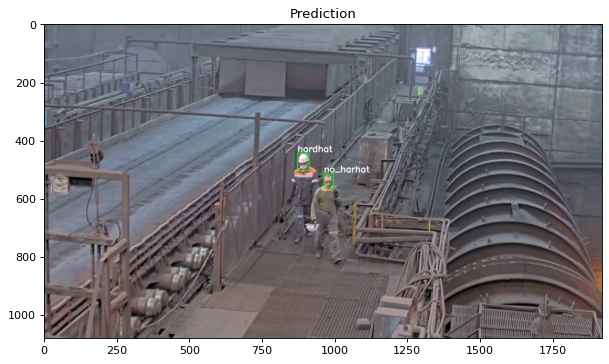

Объектов класса hardhat обнаружено 1
Объектов класса no_harhat обнаружено 1


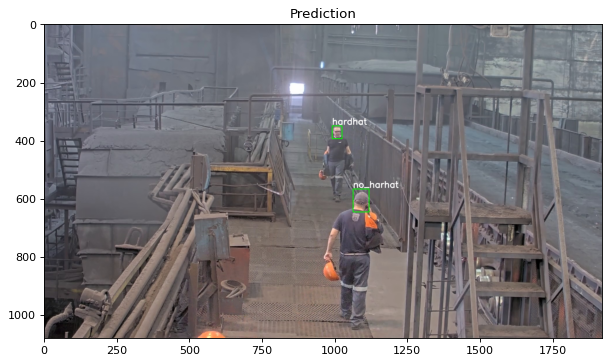

Объектов класса hardhat обнаружено 2


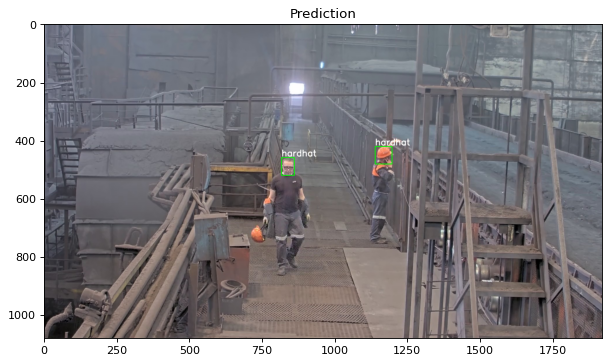

In [ ]:
from predict import *
detect_and_visualize(image_input='detect_hat_dataset/images/am3_6_frame084.jpg',
                     model_path='models/model_hardhat_detection_final.pth',
                     classes=['hardhat','no_harhat'], plt_show=True,
                     treshhold=0.6)
detect_and_visualize(image_input='detect_hat_dataset/images/am3_9_frame090.jpg',
                     model_path='models/model_hardhat_detection_final.pth',
                     classes=['hardhat','no_harhat'], plt_show=True,
                     treshhold=0.6)
detect_and_visualize(image_input='detect_hat_dataset/images/am3_9_violation_frame103.jpg',
                     model_path='models/model_hardhat_detection_final.pth',
                     classes=['hardhat','no_harhat'], plt_show=True,
                     treshhold=0.6)

### Оценка качества модели:

Выберем за treshold значение score = 0.6 (выбрал эмпирически)

Оценим качество модели используя метрику IOU:

In [37]:
'''
Найдем первым этапом iou scores:
Получим массив с числом элементов равным чилу объектов в датасете 
и содержащим массив соответвий IOU между предсказанным и рельным bounding боксом
'''
from metrics import calculate_iou
iou_scores_list = calculate_iou(model, val_dataset, treshold=0.6)

Вычислим средний IOU на валидации при заданном пороге score = 0.6

In [38]:
val = []
for image in iou_scores_list:
    for detect in image:
        val.append(max(detect))
print(f'Средний IOU на валидации равен: {np.mean(val)}')

Средний IOU на валидации равен: 0.8456330895423889


Данный скор определен по задетектированным областям. Но сама модель очень часто не находит объекты или путает классы между собой, поэтому более объективным параметром для оценки качества будет являться среднее значение AP между классами - mAP

Визуализируем как выглядят предсказанные и реальные bounding боксы на изображениях из валидационного датасета и найдем IOU для них:
PS: (в данной кастомной функции строятся сразу все предсказанные боксы, для которых score>0)

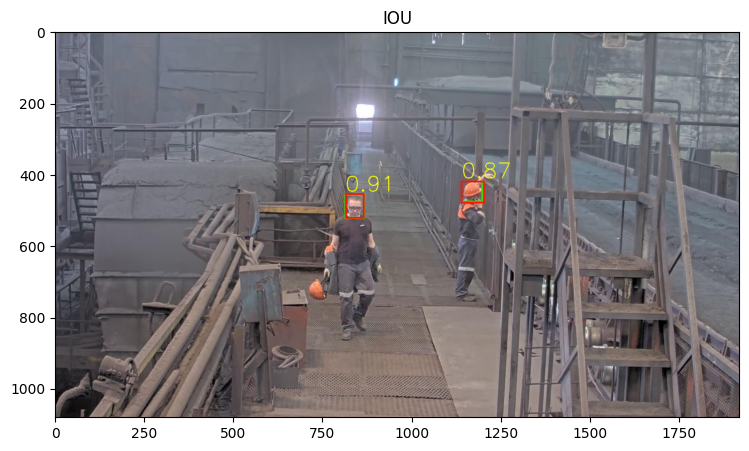

In [52]:
visualize_detection(val_dataset, model, 5)

Определим значение метрик mAP при разных значениях порга IoU, а также значения AP для обоих классов:

Найдем данные метрики соединив все предикты и таргеты на валидационном датасете воедино (а не как средний map по изображениям датасета):

In [39]:
mAP_AP_dataset(val_dataset, model, multiclasses=True)

100%|██████████| 38/38 [01:52<00:00,  2.97s/it]




Значения Average Precision для каждого класса:
AP (среднее по порогам IoU=.50:.05:.95) для класса WITH HARDHAT = 0.6938
AP (среднее по порогам IoU=.50:.05:.95) для класса WITHOUT HARDHAT = 0.7347


Значения Mean Average Precision:
mAP (среднее по порогам IoU=.50:.05:.95) = 0.7143
mAP (при IoU=.50) = 0.9868
mAP (при IoU=.70) = 0.8487
mAP (для малых объектов, у которых площадь < 32*32 пикселя) = 0.5193
mAP (для средних объектов, у которых площадь от 32*32 до 64*64 пикселя) = 0.695
mAP (для больших объектов, у которых площадь > 64*64 пикселя) = 0.8381


## __Вывод по двухклассовой детекции:__<br>
На этот раз мы получили более низкие значения метрик качества на валидации. <br>
Причиной этого может являться малый размер тренировочного датасета, низкая степень разнообразия самих фотографий в датасете (из-за чего обобщать модели сложно), высокая сложность самой поставленной задачи и очень сильная разница в априорной вероятности классов в датасете.
Фотографий с людьми без касок на трейне очень мало, поэтому значения recall для класса "без каски" на валидации получился очень низкий. Метрика AP для этого класса является низкой. <br>
Но при этом модель достаточно точно научилась находить людей с каской (метрики для данного класса на порядок лучше)<br>
Так что можно считать, что модель умеет неплохо находить людей в каске, но со скрипом людей без нее.

Попробуем сделать детекцию на незнакомых и непохожих фотографиях на датасет:

Объектов класса hardhat обнаружено 5


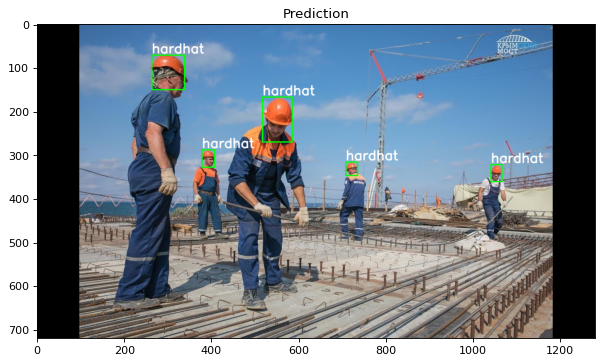

Объектов класса hardhat обнаружено 1
Объектов класса no_harhat обнаружено 7


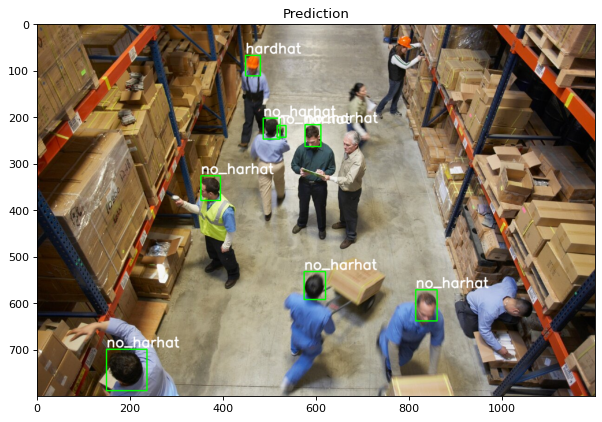

In [66]:
detect_and_visualize(image_input='test_folder/2.jpg',
                     model_path='models/model_hardhat_detection_final.pth',
                     classes=['hardhat','no_harhat'], plt_show=True, treshhold=0.5)
detect_and_visualize(image_input='test_folder/3.jpg',
                     model_path='models/model_hardhat_detection_final.pth',
                     classes=['hardhat','no_harhat'], plt_show=True, treshhold=0.5)